This is code for defining and training a model

In [ ]:
#Necessary imports
import numpy as np
from torch import nn
import torch
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import numpy as np
import time, os
from torch.autograd.functional import jacobian
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.neighbors import NearestNeighbors

print(f'Cuda is availabile? {torch.cuda.is_available()}')
device = "cuda" if torch.cuda.is_available() else "cpu"
version = torch.version.cuda
print(f"Using device: {device}")
print(f"version: {version}")

NEURONS = 45  # Number of neurons in fully connected layers
STATES = 3    # Number of state variables
PARAMETERS = 1 # Number of parameters
class suNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(STATES + PARAMETERS, NEURONS)  # 3 inputs (state variables and parameter) and 45 outputs
        self.layer_2 = nn.Linear(NEURONS, NEURONS)  # 45 inputs and 45 outputs
        self.layer_3 = nn.Linear(NEURONS, STATES)  # 45 inputs and 2 outputs (the state variables are the two outputs)
        self.layer_4 = nn.Linear(STATES,NEURONS)  # 45 inputs and 2 outputs (the state variables are the two outputs)
        self.active = nn.Tanh()
    def forward(self, x):
        input1 = x
        x = self.layer_1(x) # Apply ReLU after the first layer
        x = self.active(x)
        x = self.layer_2(x) # Apply/ ReLU after the second layer
        x = self.active(x)
        x = self.layer_2(x) # Apply/ ReLU after the second layer
        x = self.active(x)
        x = self.layer_2(x) # Apply/ ReLU after the second layer
        x = self.active(x)
        x = self.layer_3(x)  # Third layer (no activation after this)
        x = x + input1[:, :STATES]  # Add the original state variables to the output
        return x


class Trainer():
    """A Class containing all the things we need to train, test, and analyze the model.

    Attributes:
        epochs (int)                                 : The number of training epochs.
        model (torch.nn.Module)                      : The neural network model to be trained.
        model_path (str)                             : The path where the trained model will be saved.
        loss_fn (torch.nn.modules.loss._Loss)        : The loss function used for training.
        optimizer (torch.optim.Optimizer)            : The optimizer used to update model weights.
        training_set (torch.utils.data.Dataset)      : The dataset used for training.
        testing_set (torch.utils.data.Dataset)       : The dataset used for testing.
        ode (function)                               : The ordinary differential equation function for generating true data.
        delta (float)                                : The time step for generating data
        train_losses (list of float)                 : List to store the training losses for each epoch.
        test_losses (list of float)                  : List to store the testing losses for each epoch.
        training_time (float)                        : Total time taken for training in seconds.
        training_set_length (int)                    : The number of samples in the training set.
    """

    def __init__(self, ode, delta, epochs, model, model_path, loss_fn, optimizer, training_set, testing_set):
        self.epochs = epochs
        self.model = model
        self.model_path = model_path
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.training_set = training_set
        self.testing_set = testing_set
        self.ode=ode
        self.delta = delta #The time step to train the model on

        self.train_losses = []
        self.test_losses = []
        self.training_time = 0
        self.training_set_length = len(training_set)
        self.losses_path = model_path.replace('.pt', '_losses.pt')

    def loadModel(self):
        """Load the model from the model path"""
        self.model.load_state_dict(torch.load(self.model_path))
        self.model.eval()
        self.load_losses()
        print(f'Loaded model: {self.model_path} and losses')
    def trainModel(self):
        """Train the model on the training set and calculate the losses. Saves when done."""
        print('Starting training...')
        BATCH_SIZE = 64              # Batch size for training and testing
        PRINT_EVERY = self.epochs/10 # How often to print the status
        # Create DataLoader for training and testing sets
        train_loader = DataLoader(self.training_set, batch_size=BATCH_SIZE, shuffle=True)
        test_loader = DataLoader(self.testing_set, batch_size=BATCH_SIZE, shuffle=False)

        total_time = 0
        for epoch in range(self.epochs):
            start_time = time.time()
            self.model.train()

            epoch_train_loss = 0  # Track loss for this epoch
            for inputs, targets in train_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = self.model(inputs)
                loss = self.loss_fn(outputs, targets)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                epoch_train_loss += loss.item()

            self.train_losses.append(epoch_train_loss)

            # Evaluate on test data
            test_loss = evaluate_model(self.model, test_loader, self.loss_fn)
            self.test_losses.append(test_loss)

            epoch_time = time.time() - start_time
            total_time += epoch_time

            if epoch % PRINT_EVERY == 0:
                percentage = 100 * epoch / self.epochs
                print(f"Percentage: {percentage:.1f}% | Epoch: {epoch} | "
                    f"Train Loss: {epoch_train_loss:.8f} | Test Loss: {test_loss:.8f} "
                    f"Time this epoch: {epoch_time:.2f}s | Total time: {total_time:.2f}s")

        # Save the model after training
        print('Finished training. Saving...')
        self.training_time = total_time
        torch.save(self.model.state_dict(), self.model_path)
        self.save_losses()
        print('Done.')
    def plot_losses(self, title = "default loss title"):
        """Generate a graph of the losses"""
        plt.figure(figsize=(10, 5))
        epochs_range = range(1, self.epochs + 1)
        plt.loglog(epochs_range, self.get_train_losses(), label='Training Loss')
        plt.loglog(epochs_range, self.get_test_losses(), label='Testing Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        #plt.ylim([1e-9,0.001])
        plt.suptitle(f'{title}')
        plt.title(f' Total training time: {self.training_time:.2f}s over {self.epochs} epochs| {self.training_set_length} data points')
        plt.legend()
        plt.grid(True)
        plt.show()

    def save_losses(self):
        """Save the training and testing losses to a file based on the model path"""
        losses = {
            'train_losses': self.train_losses,
            'test_losses': self.test_losses
        }
        torch.save(losses, self.losses_path)
        print(f'Losses saved to {self.losses_path}.')

    def load_losses(self):
        """Load the training and testing losses from a file based on the model path"""
        losses = torch.load(self.losses_path)
        self.train_losses = losses['train_losses']
        self.test_losses = losses['test_losses']
        print(f'Losses loaded from {self.losses_path}.')


    def get_train_losses(self):
        return self.train_losses

    def get_test_losses(self):
        return self.test_losses

    def plot_comparison(self,steps, inits, beta, title = "default comparison title"):
        """Plots a graph of predicted the predicted solution and the true solution
           along with a plot of the l1 errors and a phase plane simulation.

           Parameters:
                steps(int)      :  Number of time steps to simulate the model for
                inits(float[3]) :  Initial condition to start the simulation
                beta(float)     :  Parameter value to be used in the model
                title:(str)     :  Title of the plot
                """
        TIME_LENGTH = steps * self.delta
        RESOLUTION = 2000 #Number of time steps in the ODE simulation
        #initial conditions to test our model from
        init = np.array([inits[0],inits[1],inits[2],beta])
        s = np.linspace(0, TIME_LENGTH, steps)
        #Initialized the predictions
        model_prediction_s = np.zeros(steps)
        model_prediction_e = np.zeros(steps)
        model_prediction_i = np.zeros(steps)
        #Convert the init to a torch to input into the model (DO NOT TOUCH)
        input = torch.transpose(torch.from_numpy(init).unsqueeze(1).float(),0,1)
        input = input.to(device)
        model_prediction_s[0]= inits[0]
        model_prediction_e[0]= inits[1]
        model_prediction_i[0]= inits[2]
        with torch.inference_mode():
            for i in range(1,steps):
                output =  self.model(input) #+input[:, :-1]
                model_prediction_s[i]= output[0][0].item()
                model_prediction_e[i]= output[0][1].item()
                model_prediction_i[i]= output[0][2].item()
                #Add the parameter back onto the output
                c=torch.tensor([[beta]]).to(device)

                #The new input is the old output
                input = torch.cat((output,c),dim=1)

                '''if (i% 10 == 0):
                    print(f'State position: {output}| time t={time[i]}')'''

        #Generated true solutions
        time = np.linspace(0,TIME_LENGTH,RESOLUTION) #The step size should be aligned with time step in the model
        true = odeint(self.ode, inits, time, args=(beta,))
        trueS,trueE,trueI = true[:,0],true[:,1],true[:,2]

        trueS_interp = np.interp(s, time, trueS)
        trueE_interp = np.interp(s, time, trueE)
        trueI_interp = np.interp(s, time, trueI)

        error_s = np.abs(model_prediction_s - trueS_interp)
        error_e = np.abs(model_prediction_e - trueE_interp)
        error_i = np.abs(model_prediction_i - trueI_interp)
        error_total= error_s + error_e+error_i

        #Timeseries will be large on the left, errors are top right, phase plane is bottom right
        fig = plt.figure(constrained_layout=True)
        ax = fig.subplot_mosaic([['TimeSeries', 'Errors'],['TimeSeries', 'PhasePlane']],
                                gridspec_kw={'width_ratios':[2, 1]})


        saturated_colors = {
            's':  '#191970',
            'e': '#556B2F',
            'i': '#B22222',
            'total': '#000000'
        }

        colors = {
            's': '#6A5ACD',
            'e':'#3CB371',
            'i': '#FF6347'
        }

        phaseplane_colors = {
            'true' : '#00BFFF',
            'pred' : '#000000'
        }
        # Plot time series
        ax['TimeSeries'].plot(time, trueS, color=colors['s'], linestyle='--', label='True S')
        ax['TimeSeries'].plot(time, trueE, color=colors['e'], linestyle='--', label='True E')
        ax['TimeSeries'].plot(time, trueI, color=colors['i'],  linestyle='--', label='True I')
        ax['TimeSeries'].plot(s, model_prediction_s,  color=colors['s'], linestyle='-', label='Predicted S')
        ax['TimeSeries'].plot(s, model_prediction_e,  color=colors['e'], linestyle='-',  label='Predicted E')
        ax['TimeSeries'].plot(s, model_prediction_i,  color=colors['i'],  linestyle='-',  label='Predicted I')
        # Add titles and labels
        ax['TimeSeries'].set_title('Time Series')
        ax['TimeSeries'].legend(loc='best',fancybox=True, shadow=True, ncol=2)
        ax['TimeSeries'].set_xlabel('t')
        ax['TimeSeries'].set_ylabel('States')
        ax['TimeSeries'].grid(visible=True)

        # Plot a phase plane
        ax['PhasePlane'].scatter(model_prediction_s[0],model_prediction_i[0],  s=8, c='tab:red', marker='o', label='Initial Condition')
        ax['PhasePlane'].plot(trueS,trueI,color=phaseplane_colors['true'], linestyle='dashed', label='True Solution')
        ax['PhasePlane'].scatter(model_prediction_s,model_prediction_i, s=4, c=phaseplane_colors['pred'], edgecolor='w', alpha=1, linewidth=0.5, marker='x', label='Prediction Solution')
        #Titles and labels
        ax['PhasePlane'].set_title('Phase Plane')
        ax['PhasePlane'].legend(["True ", "Prediction"])
        ax['PhasePlane'].set_xlabel('S')
        ax['PhasePlane'].set_ylabel('I')
        ax['PhasePlane'].legend(loc='best', fancybox=True, shadow=True, ncol=1)
        ax['PhasePlane'].set_ylim(-0.03,0.085)
        ax['PhasePlane'].set_xlim(0.398,0.51)
        ax['PhasePlane'].grid(visible=True)

        # Plot Errors
        ax['Errors'].plot(s, error_s, label='l1 Error S', color=saturated_colors['s'])
        ax['Errors'].plot(s, error_e, label='l1 Error E', color=saturated_colors['e'])
        ax['Errors'].plot(s, error_i, label='l1 Error I', color=saturated_colors['i'])
        ax['Errors'].plot(s, error_total, label='l1 Error Total', color=saturated_colors['total'])
        #Titles and labels
        ax['Errors'].set_xlabel('Time')
        ax['Errors'].set_ylabel('Error')
        ax['Errors'].set_title('Error Over Time')
        ax['Errors'].set_xscale('log')
        ax['Errors'].set_ylim(-0.005,0.07)
        ax['Errors'].legend(loc='best', fancybox=True, shadow=True, ncol=1)
        ax['Errors'].grid(True)

        # Show the plot
        fig.suptitle(f'{title}' + '\n' + f'Initial conditions = {inits} | beta = {beta}')
        fig.set_size_inches(10.5, 7.5)
        fig.tight_layout()
        return fig, ax


def evaluate_model(model, test_loader, loss_fn):
    """Helper function for evaluating model on test data"""
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            total_loss += loss.item()
    return total_loss


def SEIode(f, t, beta):
    """The SEIR model rescaled and reparameterized for S,E,I"""
    s,e,i = f
    gamma, sigma,mu, nu= 0.2, 0.5, 0.3, 0.2
    dfdt = [mu*(1-s)-beta*s*i-nu*s,
            beta*s*i - (mu+sigma)*e,
            sigma*e -(mu+gamma)*i]

    return dfdt


####################################################################################
#Data related things
####################################################################################

RNG = np.random.default_rng(seed=42)
class Data():
    '''A class to handle data generation'''
    def __init__(self,ode, data_points, time_step, betas, low_state_space, high_state_space, pred_path  ,resp_path ):
        self.ode = ode
        self.data_points = data_points
        self.time_step = time_step
        self.betas = betas
        self.pred_path = pred_path
        self.resp_path = resp_path
        self.predictors, self.responses = None, None
        self.low_state_space = low_state_space
        self.high_state_space = high_state_space
        #Load the data if its there. Generate it otherwise.
        if  os.path.isfile(pred_path) and os.path.isfile(resp_path):
            self.loadData()
        else:
            self.generateData()

    def generateData(self):
        ''' Generate the data by randomly sampling statespace for each of the beta values
            then numerically integrating time_step into the future. Save the data.'''
        t=np.linspace(0,self.time_step,2)
        predictors = torch.zeros(size=(self.betas.size*self.data_points, STATES+PARAMETERS))
        responses = torch.zeros(size=(self.betas.size*self.data_points, STATES))
        for i in range(self.betas.size):
            percentage = 100*i/self.betas.size
            print(f'{percentage:.1f}% complete | generating parameter value {self.betas[i]}')
            for j in range(self.data_points):
                #Sample the statespace randomly
                z1 = RNG.uniform(low=self.low_state_space, high=self.high_state_space, size=(STATES))
                z2 = odeint(self.ode, z1, t, args=(self.betas[i],))[1] #ode input gives answer at t0 and t1, so just select solution @ t1
                predictors[i*self.data_points+j] = torch.tensor((z1[0],z1[1],z1[2],self.betas[i]))
                responses[i*self.data_points+j] = torch.tensor((z2[0],z2[1],z2[2]))
        self.predictors, self.responses = predictors, responses
        self.saveData()

    def saveData(self):
        if self.pred_path == None:
            print("You didnt generate any data!!!! I have no data in me!!!!")
        else:
            torch.save(self.predictors, self.pred_path)
            torch.save(self.responses, self.resp_path)
            print(f"Tensor saved to {self.pred_path} and {self.resp_path}")

    def loadData(self):
        print(f"Loading Tensor: {self.pred_path} and {self.resp_path}")
        self.predictors = torch.load(self.pred_path)
        self.responses = torch.load(self.resp_path)
        print(f"Loaded Tensor: {self.pred_path} and {self.resp_path}")

    def get_data(self):
        return self.predictors, self.responses


def pad_data(predictors, responses, number_of_neighbours):
    '''
    Generate additional data by averaging the nearest neighbours of each datapoint value.

    Args:
        predictors (torch.Tensor): Tensor of predictors.
        responses (torch.Tensor): Tensor of responses.

    Returns:
        torch.Tensor,  torch.Tensor : additional predictors and responses tensors, same size as input.
    '''
    start_time = time.time()
    print(f'Padding data with {number_of_neighbours} neighbours...')
    combined_data = torch.cat((predictors, responses), dim=1)
    #Seperate the data depending on which beta values are the same
    unique_b_values = torch.unique(combined_data[:, 3])
    separated_data = []
    for b_value in unique_b_values:
        mask = combined_data[:, 3] == b_value
        separated_data.append(combined_data[mask])
    #Generate the new averaged datapoints
    predictors_pad = torch.empty((0,predictors.size(1)))
    responses_pad =  torch.empty((0,responses.size(1)))
    for i, combined_data_with_same_beta in enumerate(separated_data):
                knn = NearestNeighbors(n_neighbors=number_of_neighbours + 1)
                predictors_with_same_beta = combined_data_with_same_beta[:, :4]
                responses_with_same_beta = combined_data_with_same_beta[:, 4:]
                knn.fit(predictors_with_same_beta.cpu().numpy())
                distances, indices = knn.kneighbors(predictors_with_same_beta.cpu().numpy(), return_distance=True)
                for i in indices:
                    #For each set of nearest neighbours, calculate the average
                    avg_input = predictors_with_same_beta[i].mean(dim=0)
                    avg_target = responses_with_same_beta[i].mean(dim=0)
                    #Add the averages of the to the list
                    predictors_pad = torch.cat((predictors_pad, avg_input.unsqueeze(0)), dim=0)
                    responses_pad = torch.cat((responses_pad, avg_target.unsqueeze(0)), dim=0)
    run_time = time.time() - start_time
    print(f'Done padding. Time elapsed: {run_time:.2f}')
    return predictors_pad, responses_pad

def split_data(predictors, responses, train_ratio=0.8):
    '''Split the data into training and testing sets'''
    dataset_size = len(predictors)
    train_size = int(train_ratio * dataset_size)
    test_size = dataset_size - train_size
    train_dataset, test_dataset = random_split(TensorDataset(predictors, responses), [train_size, test_size])
    return train_dataset, test_dataset

Cuda is availabile? False
Using device: cpu
version: 12.1


Here is the code to train the models and generate the figures 1,2,3,4,5 in our report. Unfortunately the data we used for the report got wiped when we lost connection, however the included code still shows improvement if not as drastic.

To avoid retraining the model, please place the files from the zip folder into the google colab files.

Due to an oversight by me, the model has to be retrained to generate the loss graphs. If you are willing to do so, it should take 10-15min on googles CPU. I am sorry for this mistake. Please uncomment lines 59 and 60 then comment lines 61 and 62 to train.

[0.8 1.  1.2 1.4 1.6]
Loading Tensor: ./predictorsNearbatch9.pt and ./responsesNearbatch9.pt
Loaded Tensor: ./predictorsNearbatch9.pt and ./responsesNearbatch9.pt
Padding data with 4 neighbours...
Done padding. Time elapsed: 4.80
Starting training...
Percentage: 0.0% | Epoch: 0 | Train Loss: 0.16352843 | Test Loss: 0.00240220 Time this epoch: 2.17s | Total time: 2.17s
Percentage: 10.0% | Epoch: 50 | Train Loss: 0.00007639 | Test Loss: 0.00002971 Time this epoch: 0.91s | Total time: 63.46s
Percentage: 20.0% | Epoch: 100 | Train Loss: 0.00003853 | Test Loss: 0.00001321 Time this epoch: 0.91s | Total time: 115.21s
Percentage: 30.0% | Epoch: 150 | Train Loss: 0.00002584 | Test Loss: 0.00001027 Time this epoch: 1.00s | Total time: 172.37s
Percentage: 40.0% | Epoch: 200 | Train Loss: 0.00001840 | Test Loss: 0.00000784 Time this epoch: 1.42s | Total time: 229.04s
Percentage: 50.0% | Epoch: 250 | Train Loss: 0.00001810 | Test Loss: 0.00000700 Time this epoch: 1.09s | Total time: 280.94s
Percen

<ipython-input-26-ba6c43d8db9f>:264: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax['PhasePlane'].scatter(model_prediction_s,model_prediction_i, s=4, c=phaseplane_colors['pred'], edgecolor='w', alpha=1, linewidth=0.5, marker='x', label='Prediction Solution')
<ipython-input-26-ba6c43d8db9f>:292: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


(<Figure size 1050x750 with 3 Axes>,
 {'TimeSeries': <Axes: label='TimeSeries', title={'center': 'Time Series'}, xlabel='t', ylabel='States'>,
  'Errors': <Axes: label='Errors', title={'center': 'Error Over Time'}, xlabel='Time', ylabel='Error'>,
  'PhasePlane': <Axes: label='PhasePlane', title={'center': 'Phase Plane'}, xlabel='S', ylabel='I'>})

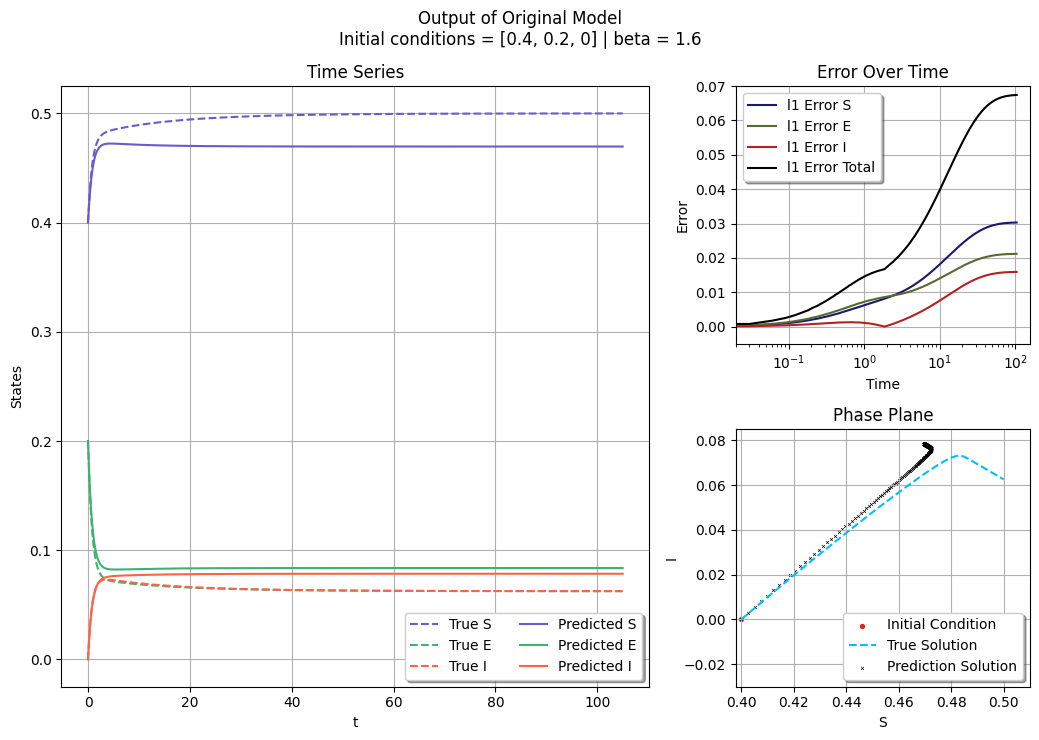

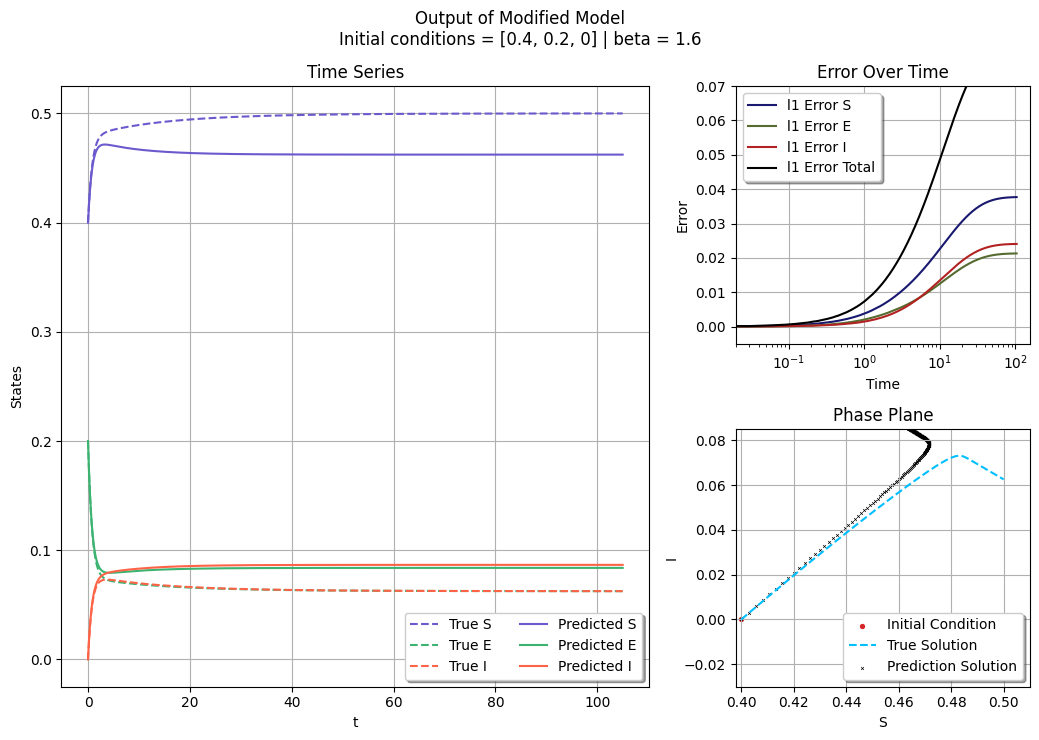

In [ ]:
#Constants
TEST =  9            #Which test we are doing
EPOCHS = 500         #20 is sometimes enough
DATA_POINTS = 7000   #How many times to sample the state space per beta value
DELTA = 0.03         #Size of the time step
PRED_PATH = './predictorsNearbatch' + str(TEST) + '.pt'
RESP_PATH = './responsesNearbatch'+str(TEST) + '.pt'
LOW_BETA =0.8       #Lower bound of the parameter to generate data
HIGH_BETA= 1.7       #Upper bound....
BETA_STEP_SIZE = 0.2 #size of steps to make
LOW_STATE_SPACE = 0  #Lower bound of the statespace sampling
HIGH_STATE_SPACE = 1 #Upper bound...

#Data generation/loading
betas = np.arange(LOW_BETA, HIGH_BETA, BETA_STEP_SIZE)
print(betas)
data = Data(SEIode, DATA_POINTS, DELTA,betas, LOW_STATE_SPACE , HIGH_STATE_SPACE , PRED_PATH, RESP_PATH)
predictors,responses = data.get_data()
# Split data into training and testing sets
train_dataset, test_dataset = split_data(predictors, responses, 0.7)
def padded_data(train_dataset):
    '''Add the averaged points by our method to the training set '''
    training_predictors, training_responses = torch.stack([x[0] for x in train_dataset]), torch.stack([x[1] for x in train_dataset])
    extra_preds, extra_responses = pad_data(training_predictors,training_responses,4)

    training_predictors = torch.cat((training_predictors, extra_preds), dim=0)
    training_responses = torch.cat((training_responses, extra_responses), dim=0)

    training_set = TensorDataset(training_predictors,training_responses)
    return training_set

model_mod   = suNet().to(device)  #Model to be trained on the original data
model_unmod =  suNet().to(device) #Model to be trained on the original data + averaged data
MODEL_PATH1 = 'modelSEI_unmod.pt'
MODEL_PATH2 = 'modelSEI_mod.pt'
Trainer_unmod = Trainer(ode  = SEIode,
                delta  = DELTA,
                epochs = EPOCHS,
                model  = model_unmod,
                model_path = MODEL_PATH1,
                loss_fn = nn.MSELoss(),
                optimizer = torch.optim.Adam(model_unmod.parameters(),0.0001),
                training_set=train_dataset,
                testing_set=test_dataset)


padded_train_dataset = padded_data(train_dataset)
Trainer_mod = Trainer(ode  = SEIode,
                delta  = DELTA,
                epochs = EPOCHS,
                model  = model_mod,
                model_path = MODEL_PATH2,
                loss_fn = nn.MSELoss(),
                optimizer = torch.optim.Adam(model_mod.parameters(),0.0001),
                training_set=padded_train_dataset,
                testing_set=test_dataset)

# Train or load the model)
Trainer_unmod.trainModel()
Trainer_mod.trainModel()
#Trainer_unmod.loadModel()
#Trainer_mod.loadModel()

#plot_losses will not function unless the model is retrained as losses are stored in memory
Trainer_unmod.plot_losses("Output of Original Model")
Trainer_unmod.plot_comparison(3500, [0.4,0.2,0], 1.6, "Output of Original Model")
Trainer_mod.plot_losses("Output of Modified Model")
Trainer_mod.plot_comparison(3500, [0.4,0.2,0], 1.6, "Output of Modified Model")

To generate the graphs where additional data is compared to the new algorithm (figure 6), you can run this code.

As before, please uncomment lines 35 and 37 then comment line 36 to generate the loss plot.

[0.8 1.  1.2 1.4]
Loading Tensor: ./predictorsNearbatch10.pt and ./responsesNearbatch10.pt
Loaded Tensor: ./predictorsNearbatch10.pt and ./responsesNearbatch10.pt
Loaded model: modelSEI_unmod_moredata.pt


<ipython-input-26-ba6c43d8db9f>:264: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax['PhasePlane'].scatter(model_prediction_s,model_prediction_i, s=4, c=phaseplane_colors['pred'], edgecolor='w', alpha=1, linewidth=0.5, marker='x', label='Prediction Solution')
<ipython-input-26-ba6c43d8db9f>:292: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


(<Figure size 1050x750 with 3 Axes>,
 {'TimeSeries': <Axes: label='TimeSeries', title={'center': 'Time Series'}, xlabel='t', ylabel='States'>,
  'Errors': <Axes: label='Errors', title={'center': 'Error Over Time'}, xlabel='Time', ylabel='Error'>,
  'PhasePlane': <Axes: label='PhasePlane', title={'center': 'Phase Plane'}, xlabel='S', ylabel='I'>})

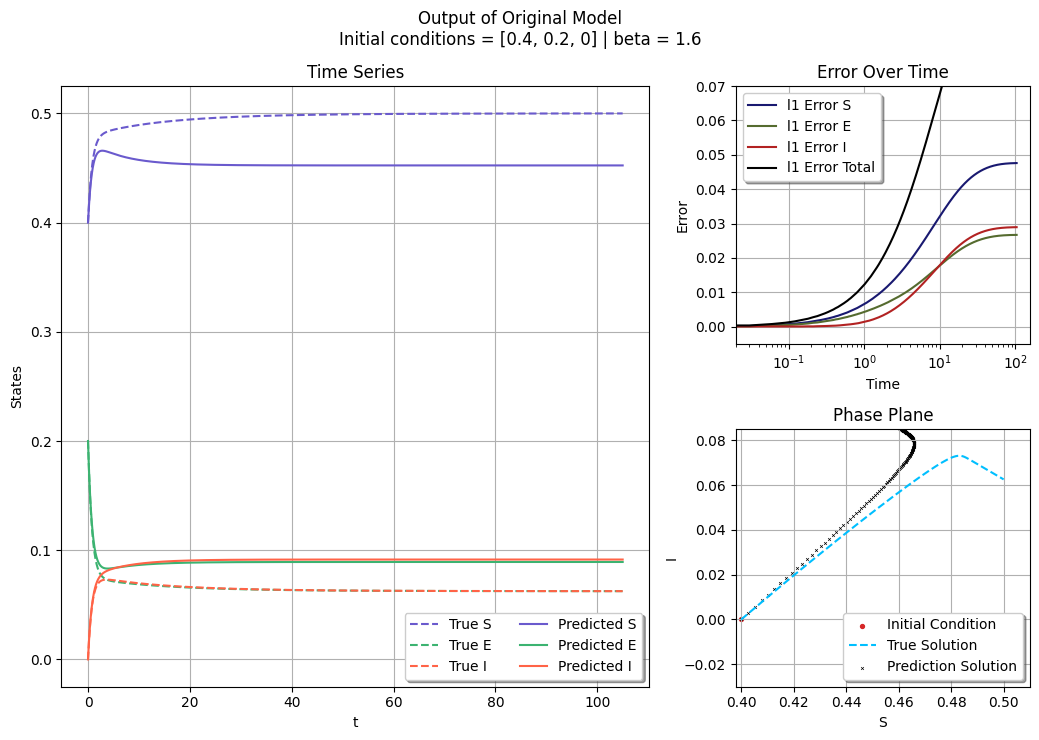

In [ ]:
#Constants
TEST =  10 #Which test we are doing
EPOCHS = 500 #20 is sometimes enough
DATA_POINTS = 14000
DELTA = 0.03 #Linspace for time. Considers only one step of size DELTA
PRED_PATH = './predictorsNearbatch' + str(TEST) + '.pt'
RESP_PATH = './responsesNearbatch'+str(TEST) + '.pt'
LOW_BETA =0.8 #Lower bound of the parameter to generate data
HIGH_BETA= 1.6 #Upper bound....
BETA_STEP_SIZE = 0.2 #size of steps to make
LOW_STATE_SPACE = 0 #Lower bound of the statespace sampling
HIGH_STATE_SPACE = 1 #Upper bound...

#Data generation/loading
betas = np.arange(LOW_BETA, HIGH_BETA, BETA_STEP_SIZE)
print(betas)
data = Data(SEIode, DATA_POINTS, DELTA,betas, LOW_STATE_SPACE , HIGH_STATE_SPACE , PRED_PATH, RESP_PATH)
predictors,responses = data.get_data()
# Split data into training and testing sets
train_dataset, test_dataset = split_data(predictors, responses, 0.7)

model_unmod_moredata=  suNet().to(device)
MODEL_PATH3 = 'modelSEI_unmod_moredata.pt'
Trainer_unmod_moredata = Trainer(ode  = SEIode,
                delta  = DELTA,
                epochs = EPOCHS,
                model  = model_unmod_moredata,
                model_path = MODEL_PATH3,
                loss_fn = nn.MSELoss(),
                optimizer = torch.optim.Adam(model_unmod_moredata.parameters(),0.0001),
                training_set=train_dataset,
                testing_set=test_dataset)

#Uncomment to train model
#Trainer_unmod_moredata.trainModel()
Trainer_unmod_moredata.loadModel()
#Trainer_unmod_moredata.plot_losses("Output of Original Model")
Trainer_unmod_moredata.plot_comparison(3500, [0.4,0.2,0], 1.6, "Output of Original Model")